# PPCA in TensorFlow Probability
This is the PPCA method applied in TensorFlow Probability (TFP) on a small set of generated data. The code is based on one of TensorFlow's tutorials of TFP. The tutorial has been extended from an $x = Wz$ model to an $x = Wz + \mu$ model. We will start with the code as given in the tutorial.

First we import necessary libraries

In [15]:
import functools
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd

tf.enable_v2_behavior()

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

We create a function of the ZIFA model:

In [16]:
Root = tfd.JointDistributionCoroutine.Root
def ZIFA(data_dim, latent_dim, num_datapoints, stddv_datapoints):
    w = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([data_dim, latent_dim]),
                 scale=3.0 * tf.ones([data_dim, latent_dim]),
                 name="w"), reinterpreted_batch_ndims=2))
#     print('w: ',w)
    z = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                 scale=2.0*tf.ones([latent_dim, num_datapoints]),
                 name="z"), reinterpreted_batch_ndims=2))
#     print('z: ',z)
    mu = yield Root(tfd.Independent(
        tfd.Normal(loc=Lambda*tf.ones([data_dim,1]),
                 scale=2.0*tf.ones([data_dim,1]),
                 name="mu"), reinterpreted_batch_ndims=1))
#     print('mu: ', mu)

    #### Unfortunately h does not work as a Bernoulli process yet, but it does work when h is a batch of Gaussian processes
    
#     h = yield Root(tfd.Independent(
#         tfd.Bernoulli(probs=np.exp(-10*tf.matmul(w, z)+mu), dtype=tf.float32, name='h'), reinterpreted_batch_ndims=1))
    h = yield Root(tfd.Independent(
        tfd.Normal(loc=0.5*tf.ones([data_dim,num_datapoints]),
                 scale=tf.ones([data_dim,num_datapoints]),
                 name="h"), reinterpreted_batch_ndims=1))
    
#     print(Root(tfd.Independent(     ## As a Bernoulli process
#         tfd.Bernoulli(probs=np.exp(-10*tf.matmul(w, z)+mu), dtype=tf.float32, name='h'), reinterpreted_batch_ndims=1)))
#     print(Root(tfd.Independent(     ## as Gaussian processes
#         tfd.Normal(loc=0.5*tf.ones([data_dim,5000]),
#                  scale=tf.ones([data_dim,5000]),
#                  name="h"), reinterpreted_batch_ndims=1)))

#     print('h: ',h)

    x_bool = yield tfd.Independent(tfd.Normal(
        loc=(tf.matmul(w, z)+mu)*h,
        scale=stddv_datapoints*h,
        name="x_bool"), reinterpreted_batch_ndims=2)
#     print('x: ', x_bool)
    
num_datapoints = 5000
data_dim = 2
latent_dim = 1
stddv_datapoints = 0.5
Lambda = 10.0

concrete_ZIFA_model = functools.partial(ZIFA,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_datapoints,
    stddv_datapoints=stddv_datapoints)

model = tfd.JointDistributionCoroutine(concrete_ZIFA_model)

And we generate some data. Note the Zero inflation as depicted in the two histograms representing two genes.

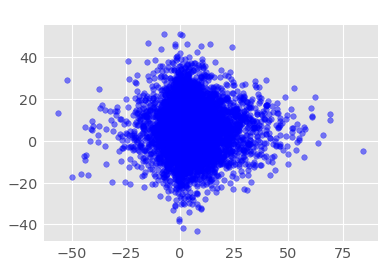

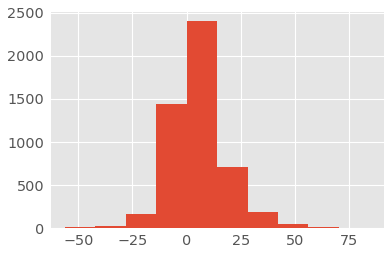

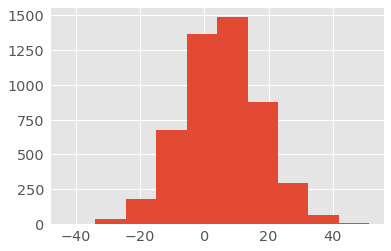

In [17]:
actual_w, actual_z, actual_mu, actual_h, x_train = model.sample()

# print("Principal axes:")
# print(actual_w)
# print(actual_z)

plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.5)
# plt.axis([-20, 20, -20, 20])
plt.title("Data set")
plt.show()
plt.hist(x_train[0, :])
plt.show()
plt.hist(x_train[1, :])
plt.show()

Then we minimize the error numerically:

Edit: Unfortunately, this part does not seem to work yet when h is a Bernoulli process. It does work when h is a Gaussian (line 20 of mainfunction), but with less than optimal results

In [18]:
def ZIFA_W(data_dim, latent_dim, num_datapoints, stddv_datapoints):
    w = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([data_dim, latent_dim]),
                 scale=3.0 * tf.ones([data_dim, latent_dim]),
                 name="w"), reinterpreted_batch_ndims=2))
#     print('w: ',w)
    z = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                 scale=2.0*tf.ones([latent_dim, num_datapoints]),
                 name="z"), reinterpreted_batch_ndims=2))
#     print('z: ',z)
    mu = yield Root(tfd.Independent(
        tfd.Normal(loc=Lambda*tf.ones([data_dim,1]),
                 scale=2.0*tf.ones([data_dim,1]),
                 name="mu"), reinterpreted_batch_ndims=1))
#     print('mu: ', mu)

    x = yield tfd.Independent(tfd.Normal(
        loc=(tf.matmul(w, z)+mu),
        scale=stddv_datapoints,
        name="x_bool"), reinterpreted_batch_ndims=2)
#     print('x: ', x_bool)
   
W_ZIFA_model = functools.partial(ZIFA_W,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_datapoints,
    stddv_datapoints=stddv_datapoints)

model_W = tfd.JointDistributionCoroutine(W_ZIFA_model)

According to Pierson (2015), $\mu$ and $W$ should be optimized first, followed by $\sigma^2$ and ending with $h$. We first optimize $\mu$ by initializing it as the mean of our observed data. We then optimalize on a separate model that doesn't contain $h$, followed by the complete model.

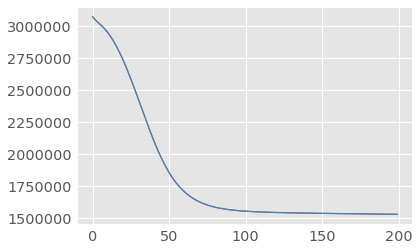

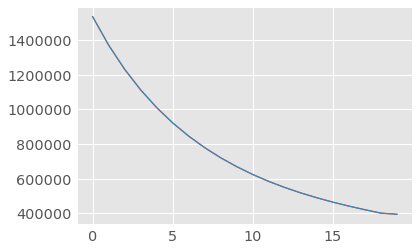

In [19]:
mu = mu_mu = tf.expand_dims(tf.reduce_mean(x_train, 1),1)

w = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
z = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)
h = tf.Variable(np.ones([data_dim, num_datapoints]), dtype=tf.float32)

target_log_prob_fn = lambda w, z, mu: model_W.log_prob((w, z, mu, x_train))
losses = tfp.math.minimize(lambda: -target_log_prob_fn(w, z, mu),
                           optimizer=tf.optimizers.Adam(learning_rate=0.05),
                           num_steps=200)
plt.plot(losses)
plt.show()
# print(losses)

target_log_prob_fn = lambda w, z, mu, h: model.log_prob((w, z, mu, h, x_train))
losses = tfp.math.minimize(lambda: -target_log_prob_fn(w, z, mu, h),
                           optimizer=tf.optimizers.Adam(learning_rate=0.05),
                           num_steps=200)
plt.plot(losses)
plt.show()
# print(losses)

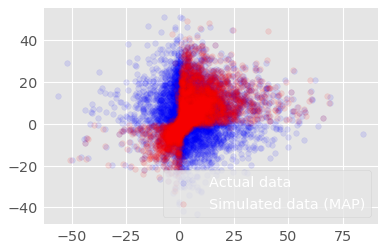

In [20]:
_, _, _, _, x_generated = model.sample(value=(w, z, mu, h, None))

plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated[0, :], x_generated[1, :], color='red', alpha=0.1, label='Simulated data (MAP)')
plt.legend()
# plt.axis([-20, 20, -20, 20])
plt.show()